## Проект по прогнозированию настроений сотрудников компании «Работа с заботой»

In [1]:
!pip install shap -q 
!pip install -Uq scikit-learn -q 
!pip install phik -q

In [2]:
import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.metrics import (f1_score,mean_squared_error, mean_absolute_error,
                             accuracy_score, recall_score, precision_score, make_scorer)

from sklearn.metrics import roc_auc_score, RocCurveDisplay

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler,
                                   PolynomialFeatures, 
                                   OneHotEncoder,
                                   OrdinalEncoder, 
                                   LabelEncoder)

from sklearn.impute import SimpleImputer
#from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from warnings import simplefilter

import shap
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix



In [3]:
def researchvis_num_features(df, df_features, color):
    
    for feat in df_features:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        sns.histplot(ax=ax[0], data=df, x=df[feat], kde=True, bins=30, color=color)
            
        ax[0].set_ylabel('Частота')
        ax[0].set_title(f'Распределение показателей {df[feat].name}', fontsize=12)
            
        sns.boxplot(ax=ax[1], data=df, x=df[feat], color=color, medianprops={'color': "darkred", "linewidth": 2})
        ax[1].set_title(f'Диаграмма размаха {df[feat].name}', fontsize = 12)
            

In [4]:
def research_vis_cat(df, df_features, palet):
    
    for feat in df_features:
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.countplot(df[feat], palette=palet, ax=ax[0])
        
        ax[0].set_xlabel(f'{df[feat].name}')
        ax[0].set_ylabel('Количество')
        ax[0].set_title(f'Cтолбчатая диаграмма {df[feat].name}', fontsize=12)
        
        ax[1].pie(df[feat].value_counts(),
                        labels=df[feat].value_counts().index, 
                        autopct='%1.1f%%', 
                        startangle=140,
                        colors=sns.color_palette(palet),
                        textprops={'color':'white'})
        
        ax[1].legend()
        ax[1].set_title(f'Круговая диаграмма {df[feat].name}', fontsize=12)
    

In [5]:
def phik_features_matrix(df, interval_cols):
    phik_overview = phik_matrix(df, interval_cols=interval_cols)

    plot_correlation_matrix(
           phik_overview.values,
           x_labels=phik_overview.columns,
           y_labels=phik_overview.index,
          title=r"Матрица корреляций $\phi_K$",
          fontsize_factor=1.5,
          figsize=(12, 9)
)

## Этап 1: Предсказание удовлетворенности работой сотрудников

### 1

In [6]:
satisfaction_train_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features_df = pd.read_csv('/datasets/test_features.csv')
target_feature = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [7]:
satisfaction_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
satisfaction_train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [9]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [10]:
test_features_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
target_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [12]:
target_feature.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## 2

In [13]:
satisfaction_train_df.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [14]:
satisfaction_train_df.loc[satisfaction_train_df['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Тут сложнее, сотрудники имеют различный трудовой стаж и уровень нагрузок, при том, что они джуниоры. Я думаю логично записать их в отдел продаж 'sales' он самый крупный в тренировочных данных.

In [15]:
satisfaction_train_df['dept'].value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [16]:
satisfaction_train_df.loc[satisfaction_train_df['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


В случае с этими пропусками не трудно догадаться, что эти специалисты постпили на работу недавно, у каждого из них трудовой стаж год, значит скорее всего это молоды специалисты, которым скорее всего еще не установили уровень должности, поставим им junior

In [17]:
satisfaction_train_df['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [18]:
satisfaction_train_df['level'] = satisfaction_train_df['level'].str.replace('sinior', 'senior')
satisfaction_train_df['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

 Пропуски заполнять не будем, это за нас сделает пайплайн.

### test_features_df

In [19]:
test_features_df.loc[test_features_df['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [20]:
test_features_df.loc[test_features_df['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [21]:
test_features_df['level'] = test_features_df['level'].str.replace('sinior', 'senior')
test_features_df['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

In [22]:
test_features_df['dept'] = test_features_df['dept'].str.replace(' ', 'sales')
test_features_df['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan],
      dtype=object)

In [23]:
test_features_df['workload'] = test_features_df['workload'].str.replace(' ', 'medium')

## 3 Исследовательский анализ данных

### satisfaction_train_df 

#### Анализ количественных непрерывных признаков

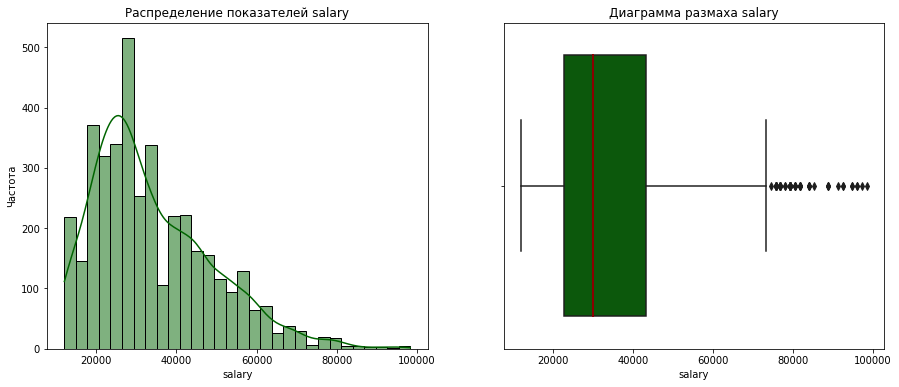

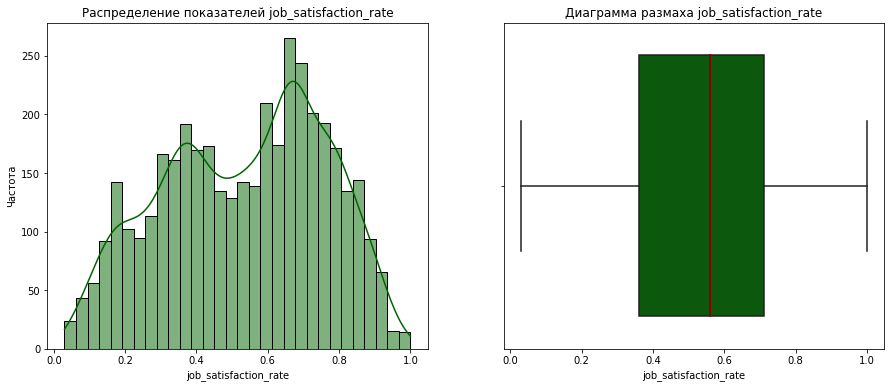

In [24]:
features_names = ['salary', 'job_satisfaction_rate']
researchvis_num_features(satisfaction_train_df, features_names, 'darkgreen')

In [25]:
satisfaction_train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4000.0,544957.621000,257883.104622,100954.00,322836.75,534082.50,771446.00,999521.0
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


#### Анализ количественных дискретных признаков

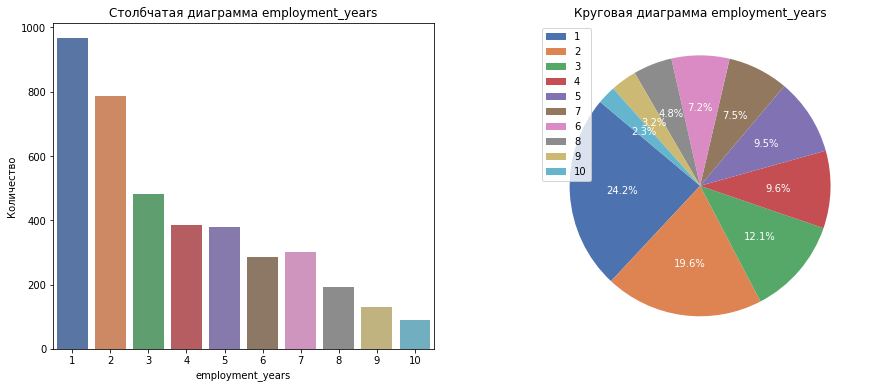

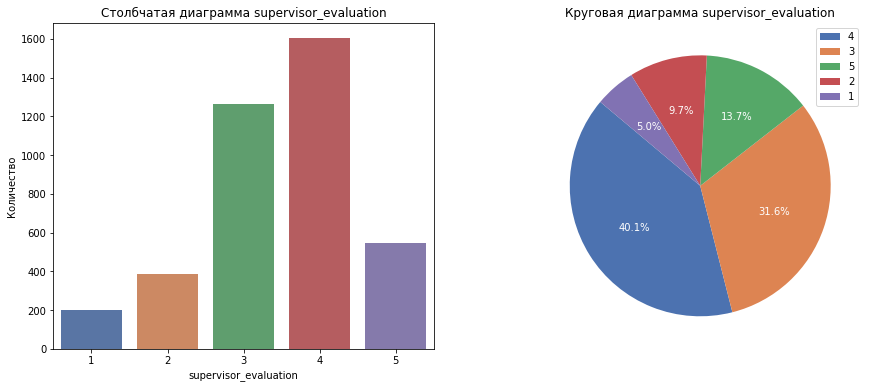

In [26]:
new_feat_names = ['employment_years', 'supervisor_evaluation']
simplefilter(action='ignore', category=FutureWarning)
research_vis_cat(satisfaction_train_df, new_feat_names, 'deep')

Картина по количесвтенным признакам скалдывается довольно ожидаемая.

  Признак рабочего стажа является дискретным, это целые значения от 1 и до 10 лет. Судя по диаграмме размах большинство значений находятся в промежутке от 2 и до 6 лет, в среднем рабочий стаж равен 3 годам. Судя по гистограмме наибольшее кол-во специалистов имеют рабочий стаж 1 год, т.е совсем недавно были приняты в компанию. Их будет сложно адекватно оценивать в дальнейшем например по признаку год без повышения.
  
  Признак описывающий оценку сотрудника от руководства тоже дискретный, целые значения от одного до пяти. Область нормальных значений от 3 до 4, т.е 60% всех оценок сотрудников средние либо хорошие, значительно реже ставят оценки 5 и 2, и меньше всего оценок в 1 балл.
  
  Признак с зарплатами работников выглядит в большинстве своем как нормальное распределение, хоть у него нету левого хвоста из-за сдвига. Поскольку большинство значений с зарплатами находится в начале рапсределния. Так большинство зарплат в компании находятся в промежутке от 20 тыс и до 45 тыс. После отметки в 45 тыс число сотрудников с более высокой зарплатой начинает падать. Так всего 5 % имеют зарплату выше 80 тыс. В среднем З/П составляет 33 тыс. В компании много новых сотрудников это так, но есть люди с большим стажем и их может не устраивать их текущая зарплата.
  
  Целевой признак удовлетворенности работы представляет собой непрерывное преимущественно нормальное распределение со значениями от 0 и до 1. На рспределние пристутвуют две ярковыраженные вершины с расположенными вокруг них значениями в диапазоне [0.3, 0.4] и [0.6, 0.8]. Из-за этих двух вершин весь диапазон значений в ген совокупности относится к области нормальных значений. В этом на самом деле нет ничего критического на текущем этапе. Абсолютно нормально, что чье-то удовлетворение работы среднее, а чье-то достаточно хорошее. Я не могу предположить насколько серьезно сотрудники могли отнестись к замериванию к их настроений в компании. В среднем удовлетворенность равна 0.5. Встречается одновременно большое кол-во, как людей с удовлетворенностью ниже среднего, но и не близкой к нулю, спрогнозировать их настроения и уход будет трудно. 

#### Анализ категориальных признаков

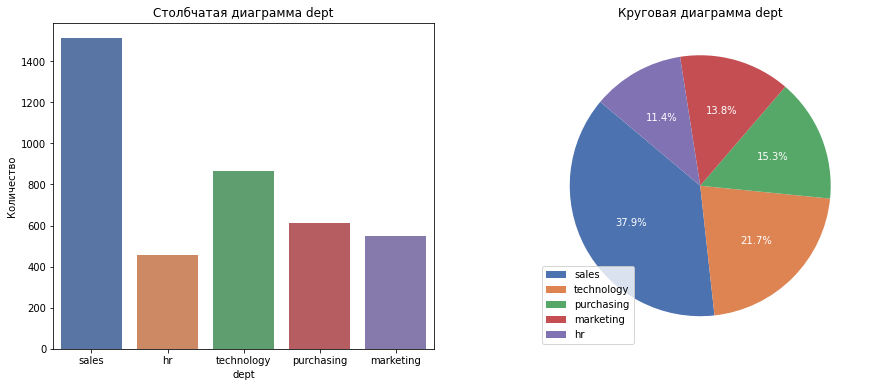

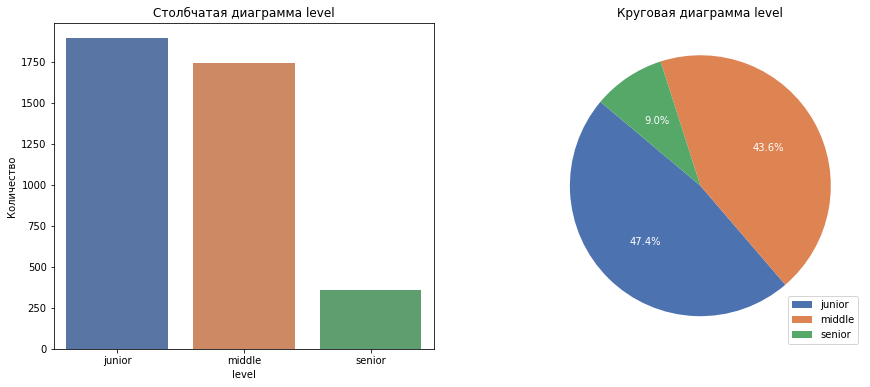

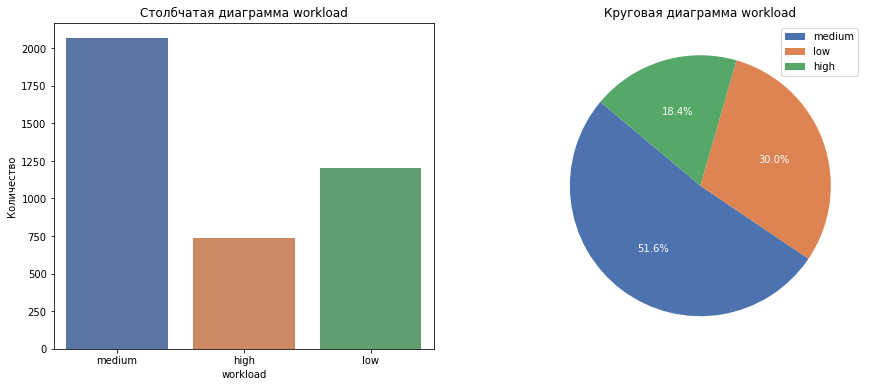

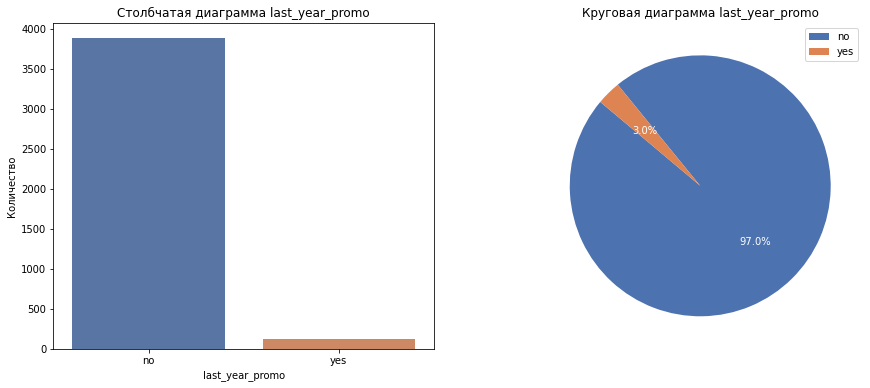

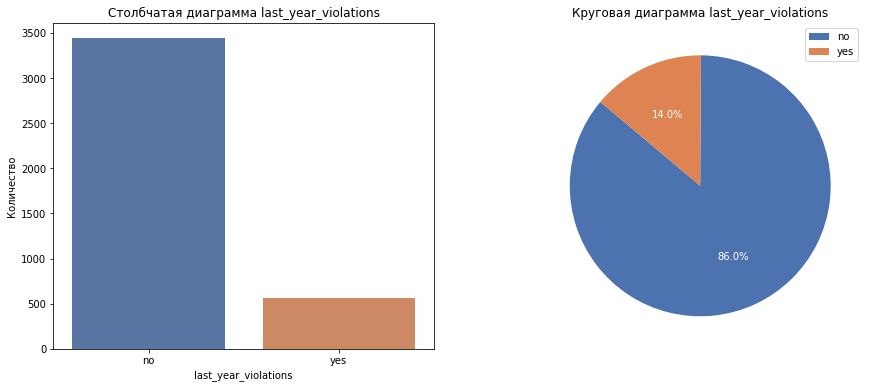

In [27]:
df_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
simplefilter(action='ignore', category=FutureWarning)
research_vis_cat(satisfaction_train_df, df_features, 'deep')

 Рассмотрим категориальные признаки. Так судя по признаку департамент сотрудника, больше всего работает в отделе продаж, свыше трети всех сотрудников, 20 % работает в отделе технолгоий и около 10 - 12 % сотрудников работает, как в отделе покупок, так и в маркетинге, и меньше всего в отдле найма, менее 10 % сотрудников. Мы лишь дополнительно подтвердили свое решение перевести в отдел продаж потеряшек.
 
 Судя по градации специальностей в компании, абсолютно баольшинство составляют джуниоры и мидл в примерно одинаковом соотношении, сеньоров же менее 10 % в компании, оно и понятно, профессионалы в меньшинстве.
 
 У половины сотрудников средняя загрузка, низкая загрузка лишь у четверти, а высокая рабочая нагрузка встречается в 20 % случаев, что абсолютно нормально, ведь все равно превальвитруют средние и низкие.
 
 Повышение не получило в прошлом году 90 % сотрудников, возможно, это повлияет на удовлетворенность работой, однако это всего лишь год, к тому же в компании множество джуниоров, а мидлу не так то просто стать сеньором.
 
 В 75 % случаев нарушений трудового договора нет, а вот в случае с нарушителями, чаша весов может склонится в сторону их увольнения.

### test_features_df

#### Анализ количественных непрерывных признаков

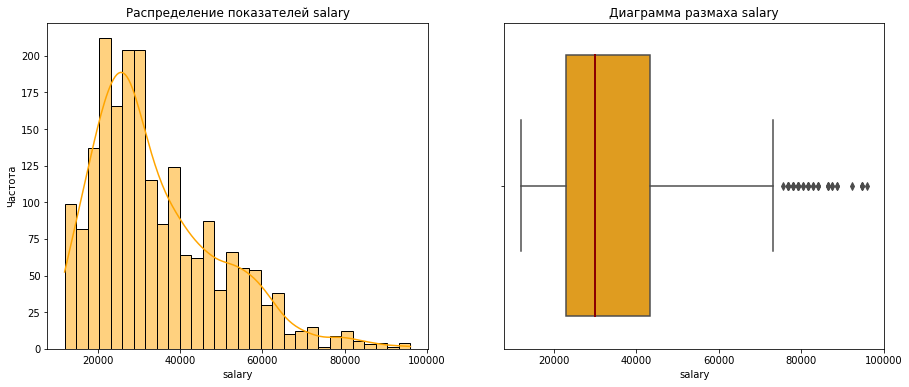

In [28]:
researchvis_num_features(test_features_df, ['salary'], 'orange')

In [29]:
test_features_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2000.0,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.00,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.00,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.00,96000.0


#### Анализ количественных дискретных признаков

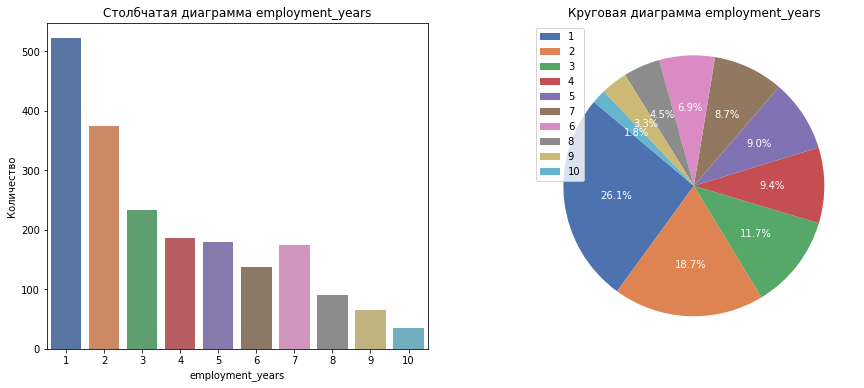

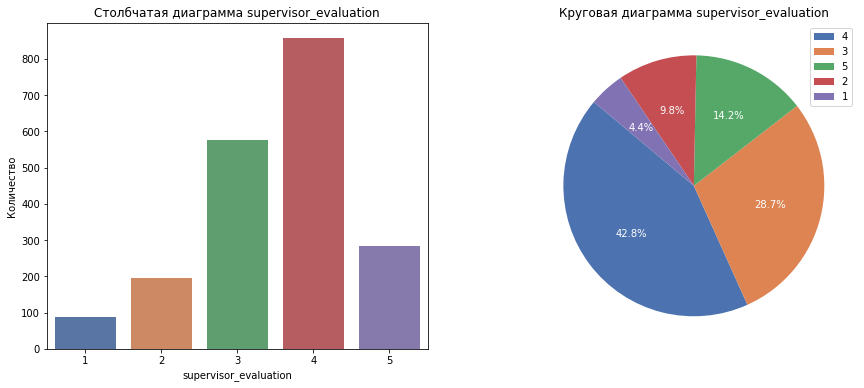

In [30]:
research_vis_cat(test_features_df, new_feat_names, 'deep')

#### Анализ категориальных признаков

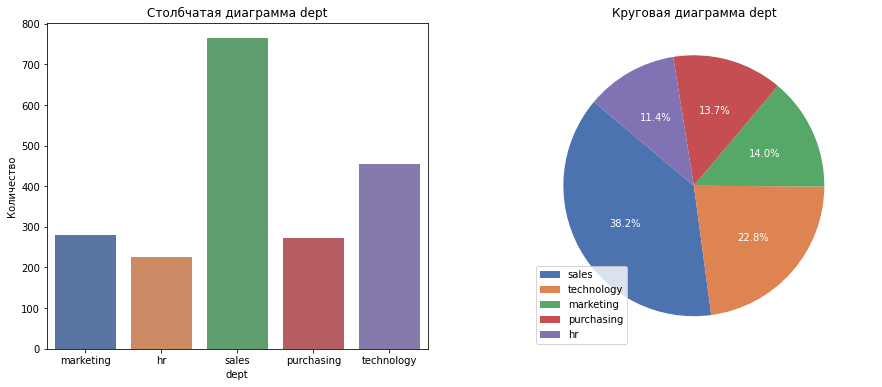

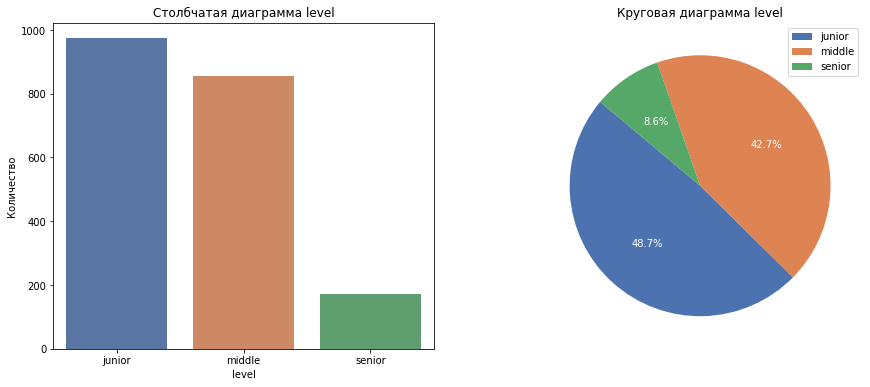

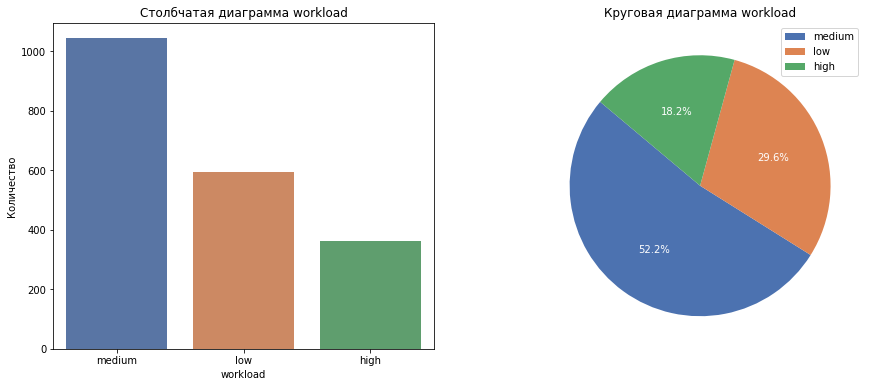

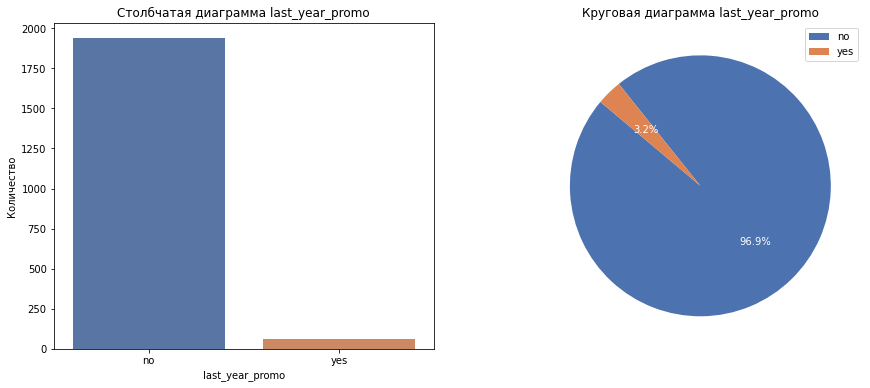

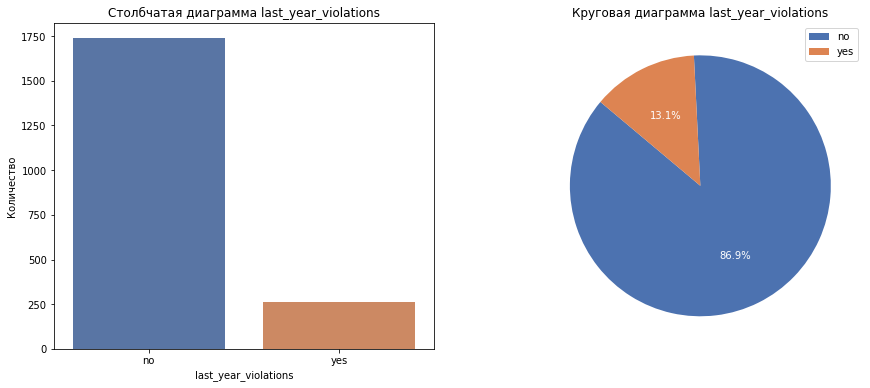

In [31]:
simplefilter(action='ignore', category=FutureWarning)
research_vis_cat(test_features_df, df_features, 'deep')

Картина скалдывается идентичная с тренировочными данными, хорошо лишьний раз удостоверится, что это так.

### Корреляционный анализ

In [32]:
interval_cols = [ 'salary', 'job_satisfaction_rate']

#### satisfaction_train_df

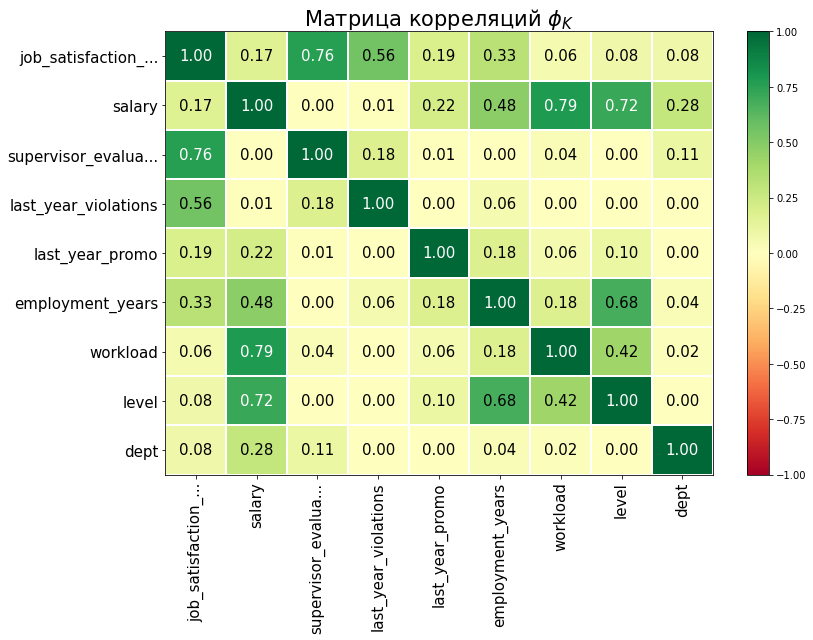

In [33]:
phik_features_matrix(satisfaction_train_df.drop('id', axis=1), interval_cols)

#### test_features_df

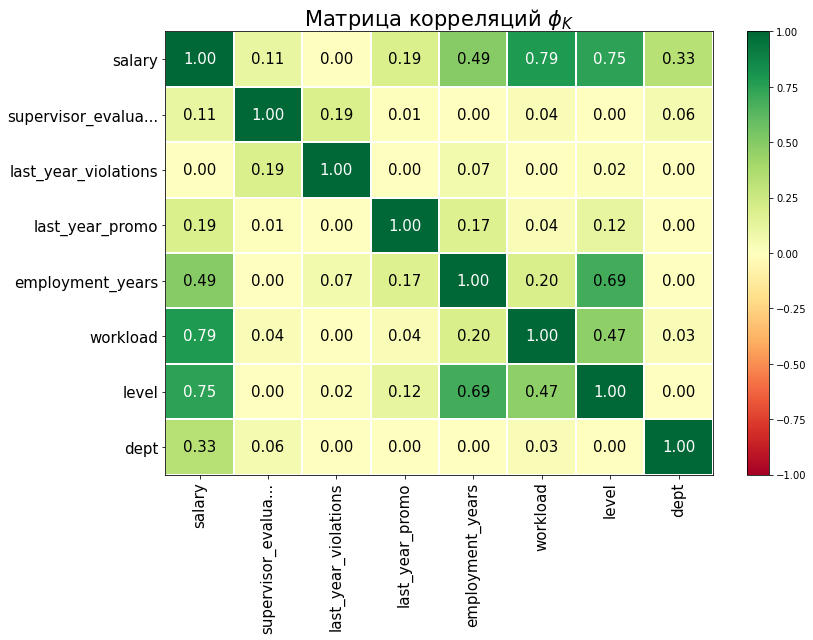

In [34]:
phik_features_matrix(test_features_df.drop('id', axis=1), ['salary'])

 В целом всё выглядит штатно, но наблюдается и мультиколлинеарности. Так присутствует сильная зависимость между рабочей нагрузкой и зарплатой, и уровнем квалификации и зарплаты, эти зависимости имеют основание, тут всё логично(профессионал или сверхурочник всегда зарабатывают больше нежели заурядные сотрудники), поэтому эти признаки можно с осторожностью отнести к необходимым для первичного обучения модели. 
 
 Что не менее важно наблюдается очень сильная зависимость между оценкой руководства и целевым признаком, целых 0.76. Следует понаблюдать за этим признаком, пока мне не очень понятно, что с этим делать. Также присутствет не слабая зависимость между нарушениями в трудвом договоре и целевым признаком, 0.56. Пока складывается ощущение, что наибольшее влияние удовлетворенность работой в компании скорее влияет оценка руководства и честная работа, а не зарплата, продвижение по карьерной лестнице или загруженость.
 

### Отбор признаков

In [35]:
satisfaction_train_df.set_index('id', inplace=True)

In [36]:
satisfaction_train_df[satisfaction_train_df.duplicated()]
satisfaction_train_df = satisfaction_train_df.drop_duplicates()

In [37]:
ord_col = ['level', 'workload']
satisfaction_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3755 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3749 non-null   object 
 1   level                  3751 non-null   object 
 2   workload               3755 non-null   object 
 3   employment_years       3755 non-null   int64  
 4   last_year_promo        3755 non-null   object 
 5   last_year_violations   3755 non-null   object 
 6   supervisor_evaluation  3755 non-null   int64  
 7   salary                 3755 non-null   int64  
 8   job_satisfaction_rate  3755 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 293.4+ KB


In [38]:
ohe_col = ['last_year_violations', 'last_year_promo', 'dept']
num_col = ['salary', 'supervisor_evaluation', 'employment_years']

In [39]:
RANDOM_STATE=42

In [40]:
ord_pipe = Pipeline([
    
    ( 'simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    (
        'ord', OrdinalEncoder(categories=[
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']
        ], handle_unknown = 'use_encoded_value', unknown_value=np.nan)
    ),
    ( 'simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

In [41]:
ohe_pipe = Pipeline(
    [( 'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),   
    ( 'ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [42]:
num_pipe = Pipeline(
    [
        (
            'simpleImputer_num', 
            SimpleImputer(strategy='median')
        ),
        (
            'scaler', 
            MinMaxScaler()
        )
    ]
)

In [43]:
data_preprocessor = ColumnTransformer(
    
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', num_pipe, num_col)
    ],
    remainder='passthrough'

)

In [44]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [45]:
param_grid  = [
    {
        'models': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_leaf_nodes': range(5, 400, 15),
        'models__min_samples_leaf': range(1, 10, 2),
        'models__min_samples_split': range(2, 10, 2),
        'models__max_depth': range(2, 150, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [46]:
def smape(y_test, y_pred):
    return 100*np.mean(2*np.abs(y_pred-y_test) / (np.abs(y_pred) + np.abs(y_test)))
    
smape_score = make_scorer(smape, greater_is_better=False)

In [47]:
rscv = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring=smape_score, n_jobs=-1, random_state=RANDOM_STATE)

In [48]:
X_train = satisfaction_train_df.drop('job_satisfaction_rate', axis=1)
y_train = satisfaction_train_df['job_satisfaction_rate']

In [49]:
test_final = test_features_df.merge(target_feature, how='left', on='id')
X_test = test_final.drop('job_satisfaction_rate', axis=1)
y_test = test_final['job_satisfaction_rate']

In [50]:
rscv.fit(X_train, y_train)

rscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer...
                                                                                               'middle',
                                                                                               'senior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['level', 'workload']),
                                                 ('num', MinMaxScaler(),
                                                  ['salary',
                                                   'supervisor_evaluation',
                                                   'employment_years'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=92, max_leaf_nodes=395,
                                       random_state=42))])

In [51]:
-rscv.best_score_

14.675151799486287

In [52]:
-rscv.score(X_test, y_test)

13.441722997531894

По итогам этой задачи:
 
   1) Собраны и преподготовлены данные, удалены пропуски и дубликаты
   
   2) Дополнительно обработаны данные с помощью пайплайнов
   
   3) обучены модели линейной регрессии и дерева решений регрессии, подобраны лучшие параметры
 
 Как видно в итоге, smape отрицательный, это значит, что модель хорошо справляется с прогнозированием и редко ошибается. Критерий успеха соблюдён, поскольку отклонение от нормы менее 15 %.
 
      DecisionTreeRegressor(max_depth=47, max_leaf_nodes=365, min_samples_leaf=3, random_state=42)
                      
 Именно эта модель зарекомендовала себя лучше всего.

## Этап 2. Предсказание дальнейших увольнений

### 1 знакомство с данными

In [53]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

In [54]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [55]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [56]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [57]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


## 2 предобработка

In [58]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')

## 3 Исследовательский анализ данных

#### Количественные непрерывные признаки

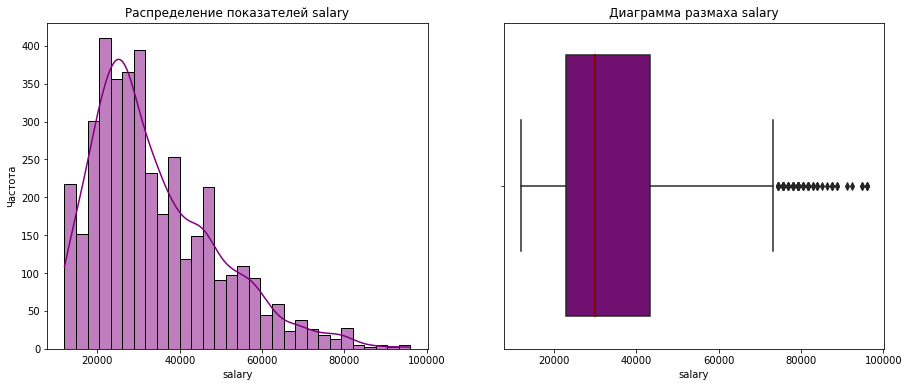

In [59]:
researchvis_num_features(train_quit, ['salary'], 'purple')

#### Количественные дискретные признаки

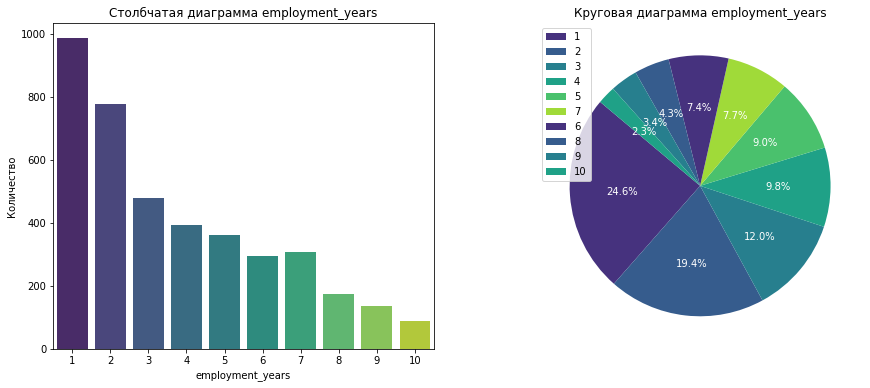

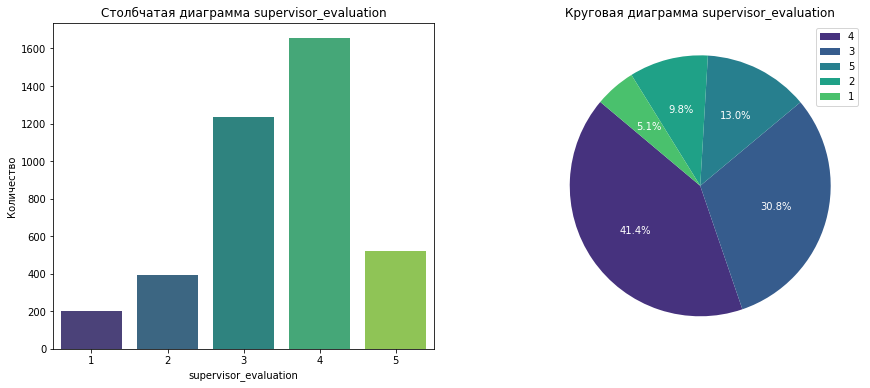

In [60]:
new_feature = ['employment_years', 'supervisor_evaluation']
research_vis_cat(train_quit, new_feature, 'viridis')

#### Категориальные признаки

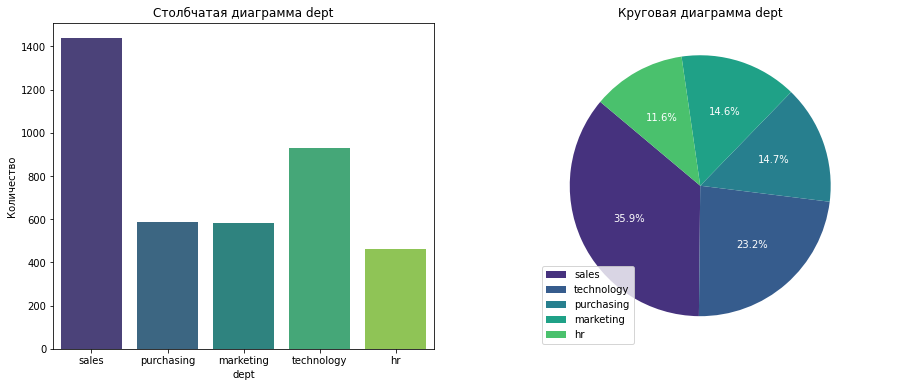

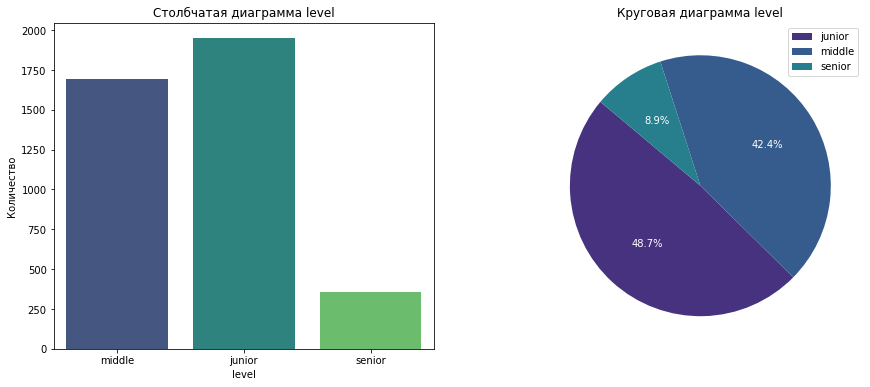

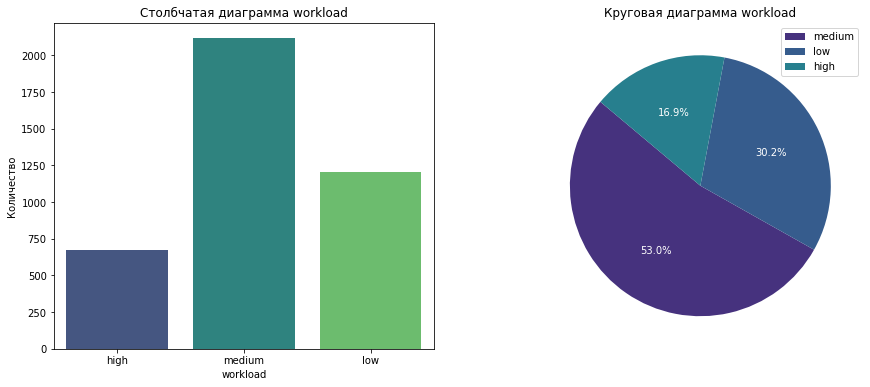

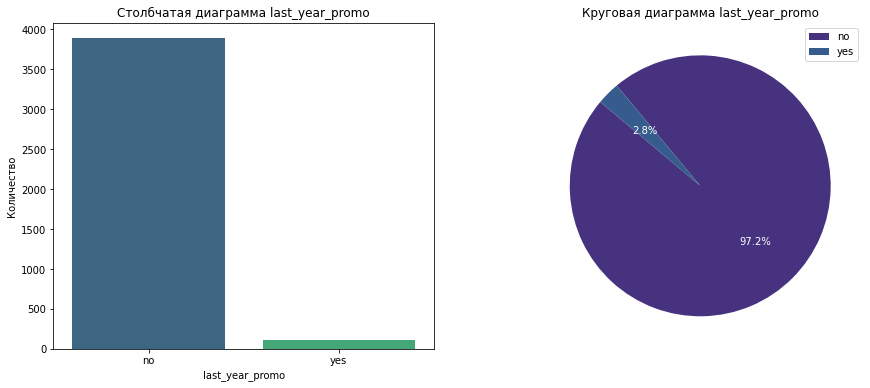

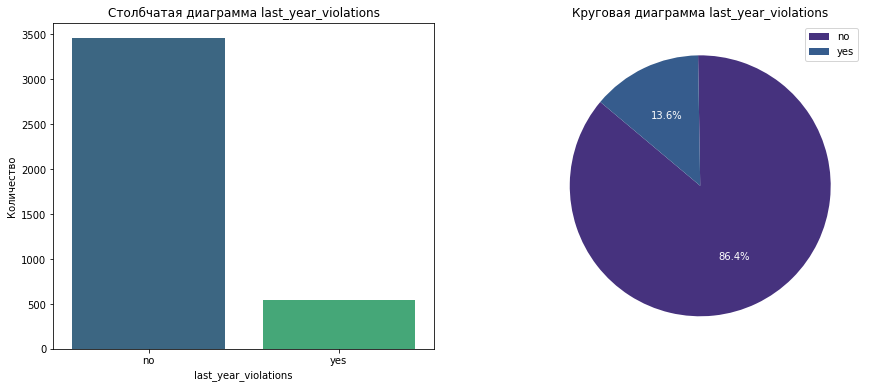

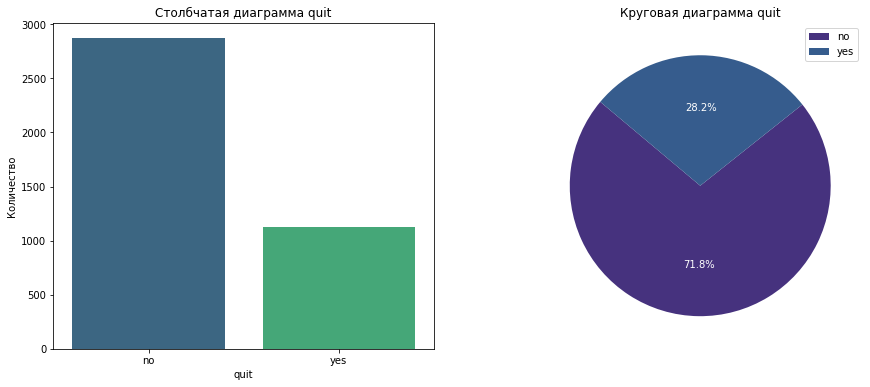

In [61]:
features_names = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
research_vis_cat(train_quit, features_names, 'viridis')

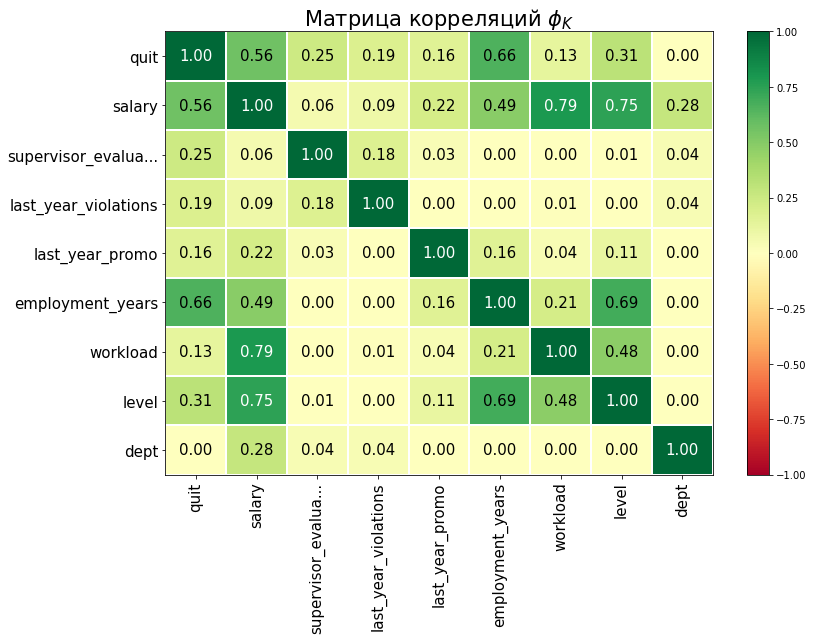

In [62]:
phik_features_matrix(train_quit.drop('id', axis=1), interval_cols)

 В большинстве своём признаковое пространство остается примерно тем же, каким оно было на первом тренировочном датасете. Доли в процентах немного изменились, но примерное соотношение и градация осталась той же. Важнее по результатам исследовательского анализ рассмотреть целевой признак и новые зависимости.
 
 Судя по уволнениям, около трети сотрудников уволилось, а 70 % остаются. Это очень высомые потери для компании. Установить причинно следственную связь нам как раз поможет матрица корреляций. Все признаки за исключением департамент имеют положительную свзязь с целевым. Однако в большинстве случаев эта зависимоть слабая, кроме двух.
 
        -  0.66 именно такая зависимость между уходом и рабочим стажем в компании, логично предположить, что увольняются те,                кто мало проработал, а остаются профессионалы, но это еще предстоит проверить.
          
        -  коэффициэнт корреляции 0.56 между целевым и зарплатой, в этой задаче как мы видим З/П играет куда большую роль.                  Низкий оклад это всегда стимул к смене работы.
          
 Между остальными признаками сохраняется привычная нам мультиколлинеарность, которая логична и легко объяснима и не требует feature engeniering.         

### 3.2 Портрет уволившегося сотрудника

In [63]:
quit_employee = train_quit.query('quit == "yes"')
quit_employee.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


In [64]:
quit_employee.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1128.0,544544.457447,258059.498361,100222.0,325073.0,545003.5,756296.0,999158.0
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


Судя по статистическим данным начинает складываться определенная картина.

   - В среднем уволившиеся сотредники проработали в фирме около двух лет(показатели ниже среднего чем на генеральной совокупности)
   - Оценка со стороны руководства в среднем равна 3, тоже показатель ниже среднего, но в пределах нормы
   - В среднем зарплата составила 23 885 у.д.е, этот показатель немногим ниже среднего
   
   На первый взгляд, кажется, что мы имеем дело с junior-специалистами, низкий стаж, средняя оценка, зп ниже среднего. Обратимся к гистограммам.

#### Численные непрерывные признаки по ушедшим сотрудникам из компании

In [65]:
quit_employee.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1128.0,544544.457447,258059.498361,100222.0,325073.0,545003.5,756296.0,999158.0
employment_years,1128.0,1.844858,1.274920,1.0,1.0,1.0,2.0,10.0
supervisor_evaluation,1128.0,3.046099,0.973291,1.0,3.0,3.0,4.0,5.0
salary,1128.0,23885.106383,9351.599505,12000.0,16800.0,22800.0,27600.0,79200.0


#### Численные дискретные признаки по ушедшим сотрудникам из компании

In [66]:
def research_vis_cat_norm(df, df_features, palet):
    
    fig, ax = plt.subplots(2, 4, figsize=(18, 11))
    
    for i, feat in enumerate(df_features):
        
        row = i // 4
        
        col = i % 4
        
        ax[row, col].pie(df[feat].value_counts(normalize=True),
                        labels=df[feat].value_counts().index, 
                        autopct='%1.1f%%', 
                        startangle=140,
                        colors=sns.color_palette(palet),
                        textprops={'color':'white'})
        
        ax[row, col].legend()
        ax[row, col].set_title(f'Круговая диаграмма {df[feat].name}', fontsize=12)
    

In [67]:
features_names = ['employment_years', 'supervisor_evaluation','dept', 'level', 'workload',
                  'last_year_promo', 'last_year_violations', 'quit']

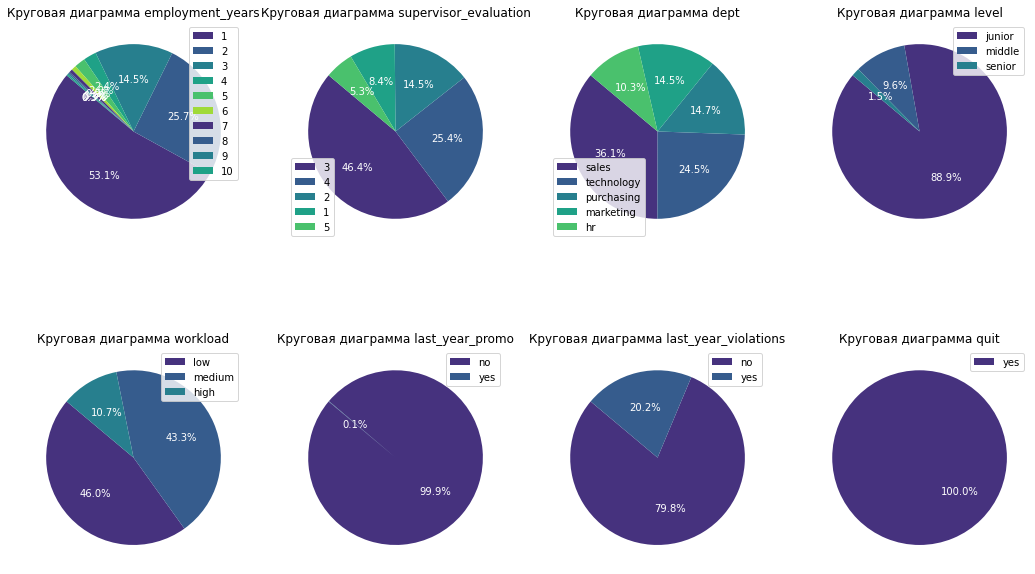

In [68]:
research_vis_cat_norm(quit_employee, features_names, 'viridis')

In [69]:
quit_employee['level'].value_counts()

junior    1003
middle     108
senior      17
Name: level, dtype: int64

In [70]:
quit_employee['level'].value_counts(normalize=True)

junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64

  Итак целевая подгруппа для нас это джуны, со средней и низкой рабочей нагрузкой, не получившие никакого повышения(хотя они итак джуны) и самое главное с преимущественну средней оценкой со стороны рукововдства. Ведь мы ранее выяснили, что влияние на целевой признак оценка со стороны руководства оказывает сильное влияние. 

  Реальная проблема и в том, что половина всех уволившихся, проработала в компании всего год и за этот год, вероятно, они не разглядели для себя серьёзных перспектив и ушли. Если переводить примерить эти цифры на ген совокупность, то получится, что 12 % сотрудников приходит в компанию и увольняется через год. 45 % проработали в компании 2-3 года. Значит суммарно 25 % всех сотрудников уволилось проработав в компании менее 4 лет. 
  
  Можно прийти к выводу, что hr отделу предстоит тщательно работать с джунами.

### 3.3 Исследование зависимости ухода сотрудника от его удовлетворенности

In [71]:
target_search = target_feature.merge(test_target_quit, on='id', how='left')
target_search.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


Text(0.5, 1.0, 'Распределение показателей удовлетворенности ушедших сотрудников')

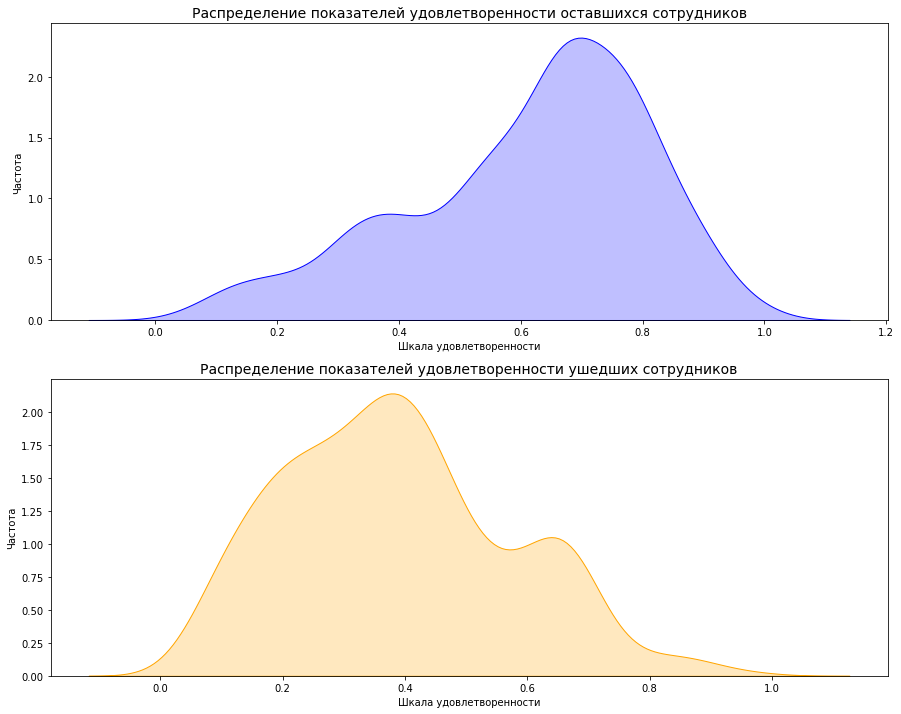

In [72]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

sns.kdeplot(ax=ax[0], data=target_search.query('quit == "no"'), x='job_satisfaction_rate', fill=True, color='blue')
ax[0].set_ylabel('Частота')
ax[0].set_xlabel('Шкала удовлетворенности')
ax[0].set_title(f'Распределение показателей удовлетворенности оставшихся сотрудников', fontsize=14)

sns.kdeplot(ax=ax[1], data=target_search.query('quit == "yes"'), x='job_satisfaction_rate', fill=True, color='orange')
ax[1].set_ylabel('Частота')
ax[1].set_xlabel('Шкала удовлетворенности')
ax[1].set_title(f'Распределение показателей удовлетворенности ушедших сотрудников', fontsize=14)

Text(0.5, 1.0, 'Диаграмма размаха значений удовлетворенности среди ушедших')

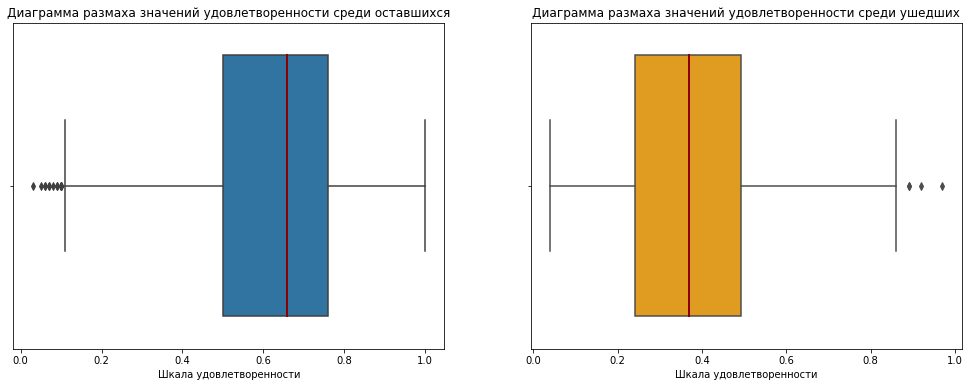

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(17, 6))
sns.boxplot(ax=ax[0], data=target_search.query('quit == "no"'), x='job_satisfaction_rate',
            medianprops={'color': "darkred", "linewidth": 2})
ax[0].set_xlabel('Шкала удовлетворенности')
ax[0].set_title('Диаграмма размаха значений удовлетворенности среди оставшихся')

sns.boxplot(ax=ax[1], data=target_search.query('quit == "yes"'), x='job_satisfaction_rate', color='orange',
            medianprops={'color': "darkred", "linewidth": 2})
ax[1].set_xlabel('Шкала удовлетворенности')
ax[1].set_title('Диаграмма размаха значений удовлетворенности среди ушедших')

In [74]:
round((426 / 564), 2)

0.76

In [75]:
target_search.query('quit == "yes"').describe().T

,count,mean,std,min,25%,50%,75%,max
id,564.0,563164.792553,251523.775926,103221.00,358969.50,554657.00,781640.2500,999029.00
job_satisfaction_rate,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


In [76]:
target_search.query('quit == "no"').describe().T

,count,mean,std,min,25%,50%,75%,max
id,1436.0,548680.699164,254730.637881,100298.00,327477.75,546372.00,761578.50,998900.0
job_satisfaction_rate,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.76,1.0


 Действительно признаки удовлетворенности сотрудников работой и фактический уход из компании связаны. Так мы видим, что большинство уволившихся, а точнее 76 % были не удовлетворены совей работой в компании, т.е имели удовлетворенность ниже средней в 0.5 по ген совокупности. 
 
 - В среднем у уволившегося удовлетворенность работой составила 0.38
 - В среднем у оставшегося сотрудника удовлетворенность работой составила 0.61
 
 Так что, можно прийти к логическому выводу, чем ниже удовлетворенность, тем больше сотрудников может уволиться из компании, но важно отметить, что при низком удовлетворении повышается лишь шанс увольнения. Масса оставшихся имеют удовлетворенность ниже среднего, а этих людей куда больше.

## 4 добавление нового входного признака

In [77]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [78]:
train_quit['job_satisfaction_rate'] = rscv.predict(train_quit)
train_quit = train_quit.set_index('id')
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.651778
814010,sales,junior,medium,2,no,no,4,27600,no,0.837297
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.360435
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,no,0.797857


In [79]:
train_quit = train_quit.drop_duplicates()
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 723290 to 692133
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


Посмотрим как изменилась матрица корреляций после появления нового признака.

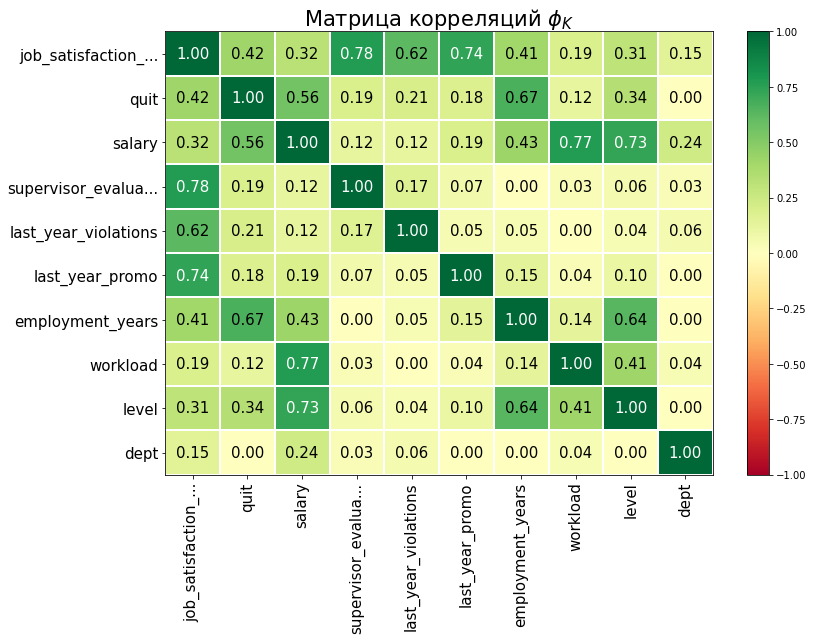

In [80]:
phik_features_matrix(train_quit, interval_cols)

Как мы видим зависимость между удовлетворенностью и уходом сотрудника есть и она составляет 0.51, это корреляционая зависимость не является сильной, о чем я писал в своем выводе и взаимосвязи между этими признаками. В остальном всё штатно.

In [81]:
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']

In [82]:
test_final = test_final.merge(target_search, on='id', how='left')
test_final['job_satisfaction_rate'] = rscv.predict(test_final.set_index('id'))
test_quit_final = test_final
test_quit_final.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_x,job_satisfaction_rate_y,quit,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,0.79,no,0.837297
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,0.72,no,0.670333
2,467458,sales,middle,low,5,no,no,4,19200,0.64,0.64,no,0.658421
3,418655,sales,middle,low,6,no,no,4,19200,0.60,0.60,no,0.658421
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,0.75,no,0.816098


In [83]:
test_quit_final = test_quit_final.drop(['job_satisfaction_rate_x', 'job_satisfaction_rate_y'], axis=1)
test_quit_final = test_quit_final.set_index('id')
test_quit_final.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.837297
686555,hr,junior,medium,1,no,no,4,30000,no,0.670333
467458,sales,middle,low,5,no,no,4,19200,no,0.658421
418655,sales,middle,low,6,no,no,4,19200,no,0.658421
789145,hr,middle,medium,5,no,no,5,40800,no,0.816098


In [84]:
X_test = test_quit_final.drop(['quit'], axis=1)
y_test = test_quit_final['quit']

In [85]:
label_encoder = LabelEncoder()

In [86]:
y_train = label_encoder.fit_transform(y_train)

In [87]:
y_train[:8]

array([0, 0, 0, 1, 0, 1, 0, 0])

In [88]:
label_encoder.inverse_transform([0, 0, 0, 1, 0, 1, 0, 0])

array(['no', 'no', 'no', 'yes', 'no', 'yes', 'no', 'no'], dtype=object)

In [89]:
y_test = label_encoder.transform(y_test)

 Уволившиеся приняты моделью за единичку, отлично

## 5 подготовка данных

In [90]:
ord_col = ['level', 'workload']
ohe_col = ['last_year_violations', 'last_year_promo', 'dept']
num_col = ['salary', 'supervisor_evaluation', 'employment_years', 'job_satisfaction_rate']

In [91]:
ord_pipe = Pipeline([
    
    ('simpleimputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
    
    ('ord', OrdinalEncoder(categories=
        [
            ['junior', 'middle', 'senior'],
            ['low', 'medium', 'high']                
        ], handle_unknown = 'use_encoded_value', unknown_value=np.nan)),
    
        ( 'simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    )
])

In [92]:
ohe_pipe = Pipeline(
    [( 'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),   
    ( 'ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [93]:
data_preprocessor = ColumnTransformer(
    
    [
        ('ohe', ohe_pipe, ohe_col),
        ('ord', ord_pipe, ord_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder='passthrough'

)

In [94]:
pipe_final = Pipeline([
    
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## 6 обучение модели

In [95]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_features': range(2, 10),
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(3, 10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
       'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler, 'passthrough']
    },
    {
        'models': [SVC(kernel = 'poly', probability=True, random_state=RANDOM_STATE)],
        'models__degree': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'models__C': range(1, 5),
        'models__penalty': ['l1','l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

In [96]:
gscv = RandomizedSearchCV(pipe_final, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)

In [97]:
X_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.651778
814010,sales,junior,medium,2,no,no,4,27600,0.837297
155091,purchasing,middle,medium,5,no,no,1,37200,0.360435
257132,sales,junior,medium,2,no,yes,3,24000,0.356875
910140,marketing,junior,medium,2,no,no,5,25200,0.797857


In [98]:
gscv.fit(X_train, y_train)

print(gscv.best_estimator_)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer_before_ord',
                                                                   

In [99]:
print('Метрика лучшей модели на тренировочной выборке:', gscv.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9030418504901775


In [100]:
y_pred = gscv.predict_proba(X_test)[:,1]

print('ROC_AUC: ', roc_auc_score(y_test, y_pred))

ROC_AUC:  0.9168135976609575


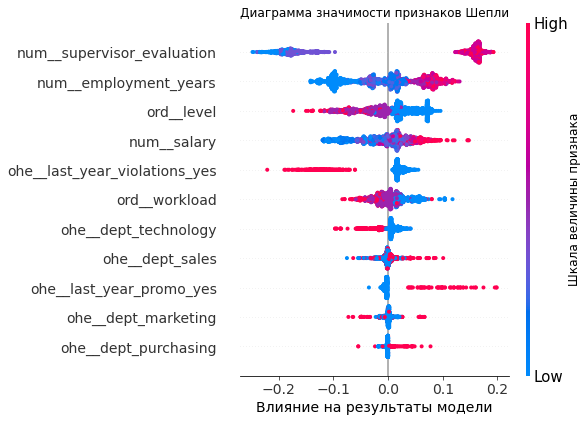

In [101]:
plt.title('Диаграмма значимости признаков Шепли', fontsize=12)
preprocessor = rscv.best_estimator_.named_steps['preprocessor']
best_model = rscv.best_estimator_.named_steps['models']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(preprocessor.transform(X_test))
shap.summary_plot(shap_values, preprocessor.transform(X_test), feature_names=preprocessor.get_feature_names_out(), show=False)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel('Влияние на результаты модели', fontsize=14)

cb_ax = fig.axes[1] 

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Шкала величины признака', fontsize=12)

plt.show()

 Лучше всех с предсказанием справляется древо классификации, а конкретно 

      DecisionTreeClassifier(max_depth=5, max_features=8, min_samples_leaf=9, min_samples_split=4, random_state=42)
     
 Для достижения этого результата была проедлана вся необходимая работа:
                
     - Добавлен новый признак - удовлетворенность работой       
     - Обучены модели(логрег, дерево решений, метод опорных векторов, метод ближайших соседей)       
     - AUC-ROC выбрана как метрика оценивания предсказаний модели, поскольку в целевом признаке наблюдается дисбаланс
     
 Наибольшим весом обладают признаки:
 
      - оценка со стороны руководства
      - рабочий стаж
      - должность
      - зарплата
      - нарушения в трудовом договре
      
  На тренировочной выборке модель показала качество в 0.90, на тестовой итоговая точность прогнозов составила 0.91. Таким образом критерий успеха выполнен, качество модели >= 0.91 AUC-ROC.

## 7 выводы

1) Решены две задачи бизнеса:
    - выполнена оценка удовлетворенности сотрудника на работе
    - выполнена классификация связанная с вероятностью увольнения сотрудника

2) В целях решения задач были обработаны данные от Заказчика, которые содержали информацию о сотрудниках:
    - уровне, загрузке, времени работы в компании, положении в компании(отделе) 
    - о его зарплате
    - об оценке руководителем и оценки удовлетворенности сотрудника
    - о факте увольнения сотрудника

 Данные успешно приведены в удобный для работы моделей вид. По результату обучения 4 моделей классификации с помощью пайплайна (логрег, опорные векторы, ближ соседи, дерево решений) и 2 моделей регрессии (дерево решений и линейная регрессия) установлено, что лучший результат дает дерево решений в обоих случаях. Точность пргоноза составила 91 %.

 Теперь перейдем к рекомендациям. Я настоятельно советую hr отделу реформировать политику отбора новых сотрудников в фирму, поскольку около 10 % сотрудников увольняются проработав в компании год, а до 25 % сотрудников работают в компании менее 4 лет. В первом случае дело в джунах, которые разочаровались в своем выборе, и здесь как раз очень важна оценка удовлетворенности работой в компании, ни сколько зарплата, сколько сами условия. Возможно, этим людям не стоило приходить в компанию и следует выбирать более мотивированных сотрудников. Однако проблема может быть глубже и начинающих специалистов вовсе не устраивает сложившаяся корпоративная культура в компании. Высокая нагрузка на работе вовсе не характерна для джуна, и эта группа требует наиболее пристального наблюдения.
 
 В случае с сотрудниками проработавшими в компании более года ситуация сложнее и как раз им нужен индивидуальный подход и проработка их проблем со специалистом из hr отдела, здесь на переднем плане стоят взаимоотношения с руководством, зарплата, нарушения в ТТК и рабочая нагрузка, а важным индикатором их настроений продолжает оставаться удовлетворенность работой. Среди уволившихся не так много мидлов и совсем мало сеньоров, но если их мало это не отменяет проблемы. Как раз именно эти люди являются ценным, а в некоторых случаях незаменимым кадровым резервом. Поэтому индивидуальный подход, как раз про них. Даже во время крупных сокращений или кризиса, сеньоры должны оставаться иначе компании грозит неминуемое кадровое голодание.
 